In [1]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

In [2]:
# Creates the antecedents, or inputs, to decide the most efficient solution.
risk = ctrl.Antecedent(np.arange(0, 101, 1), 'risk')            # Risk of the generated action
time = ctrl.Antecedent(np.arange(0, 101, 1), 'time')            # Time to execute the action
energy = ctrl.Antecedent(np.arange(0, 101, 1), 'energy')        # Considers the current energy of the system.
complexity = ctrl.Antecedent(np.arange(0, 101, 1), 'complexity')# 
impact = ctrl.Antecedent(np.arange(0, 101, 1), 'impact')        # How much it would affect the mission

# Output variable to decide the best course of action, the fuzzy set of each action depends on the State (S) of the system
action = ctrl.Consequent(np.arange(0, 11, 1), 'action')

In [3]:
# Fuzzy sets for input variables, the sets are splitted in 3 different categories which are (low, medium, high)
risk.automf(3, variable_type='quantity')
time.automf(3, 'quantity')
energy.automf(3, 'quantity')
complexity.automf(3, 'quantity')
impact.automf(3, 'quantity')

In [4]:
# Create the possible actions for each state S
def actions(state):
    action.terms = {} # Clear the terms
    if state == "S1": # Normal
        action['remain_normal'] = fuzz.trapmf(action.universe, [0, 0, 8, 10])
        action['emergency_landing'] = fuzz.trapmf(action.universe, [8, 9, 10, 10])
        return 
    elif state == "S2": # GPS Spoofing
        action['restore_attack'] = fuzz.trimf(action.universe, [0, 0, 3])
        action['change_route'] = fuzz.trimf(action.universe, [1, 3, 5])
        action['activate_redundancy'] = fuzz.trimf(action.universe, [3, 5, 7])
        action['use_occupancy_maps'] = fuzz.trimf(action.universe, [5, 7, 9])
        action['emergency_landing'] = fuzz.trimf(action.universe, [7, 10, 10])
        return
    elif state == "S3": # Jamming GPS
        action['change_altitude'] = fuzz.trapmf(action.universe, [0, 0, 2, 3])
        action['restore_system'] = fuzz.trapmf(action.universe, [1, 4, 5, 7])
        action['activate_redundancy'] = fuzz.trapmf(action.universe, [3, 6, 7, 9])
        action['emergency_landing'] = fuzz.trimf(action.universe, [7, 10, 10])
        return
    elif state == "S4": # Engine
        action['activate_redundancy'] = fuzz.trapmf(action.universe, [0, 0, 8, 10])
        action['emergency_landing'] = fuzz.trapmf(action.universe, [8 ,9, 10, 10])
    elif state == "S5": # Aileron or elevator
        action['change_altitude'] = fuzz.trapmf(action.universe, [0, 0, 8, 10])
        action['emergency_landing'] = fuzz.trapmf(action.universe, [8 ,9, 10, 10])
        return
    elif state == "S6": # Rudder
        action['navigation_adjustment'] = fuzz.trapmf(action.universe, [0, 0, 8, 10])
        action['emergency_landing'] = fuzz.trapmf(action.universe, [8 ,9, 10, 10])
        return

In [5]:
# Create the rules for the fuzzy system
def rules(state):
    if state == "S1": # Normal
        return [
            ctrl.Rule(~risk['high'] | (~energy['low'] & ~time['low']), action['remain_normal']),
            ctrl.Rule(risk['high'] & (energy['low'] & time['low']) | ~impact['low'] & ~complexity['low'], action['emergency_landing']),
            ctrl.Rule(risk['average'] & energy['average'] & time['average'], action['remain_normal']),
            ctrl.Rule(risk['low'] & energy['high'] & time['high'], action['remain_normal']),
            ctrl.Rule(complexity['high'] & impact['average'], action['emergency_landing']),
            ctrl.Rule(energy['low'] & ~risk['high'], action['remain_normal']),
            ctrl.Rule(time['low'] & ~risk['high'], action['remain_normal']),
            ctrl.Rule(impact['high'] & ~risk['high'], action['emergency_landing'])
        ]
    elif state == "S2": # GPS Spoofing
        return [
            ctrl.Rule(risk['low'] & impact['low'] & complexity['low'], action['restore_attack']),
            ctrl.Rule(time['high'] & energy['average'] & impact['average'], action['change_route']),
            ctrl.Rule(time['average'] & energy['average'] & impact['average'], action['activate_redundancy']),
            ctrl.Rule(time['low'] & energy['average'] & impact['high'], action['use_occupancy_maps']),
            ctrl.Rule((risk['high'] | complexity['high']) & energy['low'], action['emergency_landing']),
            ctrl.Rule(risk['average'] & complexity['average'], action['restore_attack']),
            ctrl.Rule(energy['high'] & impact['low'], action['change_route']),
            ctrl.Rule(time['low'] & risk['high'], action['emergency_landing']),
            ctrl.Rule(complexity['high'] & impact['high'], action['use_occupancy_maps']),
            ctrl.Rule(risk['low'] & time['high'], action['activate_redundancy'])
        ]
    elif state == "S3": # Jamming GPS
        return [
            ctrl.Rule(risk['low'] & impact['low'] & complexity['low'], action['change_altitude']),
            ctrl.Rule(time['high'] & energy['average'] & impact['average'], action['restore_system']),
            ctrl.Rule(complexity['average'] & energy['average'] & time['average'], action['activate_redundancy']),
            ctrl.Rule((risk['high'] | complexity['high'] | impact['high']) & energy['low'] & time['low'], action['emergency_landing']),
            ctrl.Rule(risk['average'] & time['average'], action['change_altitude']),
            ctrl.Rule(energy['high'] & complexity['low'], action['restore_system']),
            ctrl.Rule(impact['high'] & time['low'], action['emergency_landing']),
            ctrl.Rule(risk['low'] & complexity['high'], action['activate_redundancy']),
            ctrl.Rule(time['high'] & impact['low'], action['change_altitude']),
            ctrl.Rule(energy['low'] & impact['average'], action['restore_system'])
        ]
    elif state == "S4": # Engine
        return [
            ctrl.Rule(complexity['average'] & energy['average'] & time['average'], action['activate_redundancy']),
            ctrl.Rule((risk['average'] | complexity['average']) & energy['high'], action['activate_redundancy']),
            ctrl.Rule((risk['high'] | complexity['high']) & energy['low'], action['emergency_landing']),
            ctrl.Rule(risk['low'] & energy['average'], action['activate_redundancy']),
            ctrl.Rule(complexity['low'] & time['high'], action['activate_redundancy']),
            ctrl.Rule(impact['high'] & energy['average'], action['emergency_landing']),
            ctrl.Rule(time['low'] & risk['average'], action['activate_redundancy']),
            ctrl.Rule(energy['low'] & impact['high'], action['emergency_landing']),
            ctrl.Rule(complexity['high'] & time['average'], action['activate_redundancy'])
        ]
    elif state == "S5": # Aileron
        return [
            ctrl.Rule((risk['average'] | complexity['average']) & energy['high'], action['change_altitude']),
            ctrl.Rule((risk['high'] | complexity['high']) & energy['low'], action['emergency_landing']),
            ctrl.Rule(risk['low'] & time['high'], action['change_altitude']),
            ctrl.Rule(impact['average'] & energy['average'], action['change_altitude']),
            ctrl.Rule(complexity['low'] & time['low'], action['emergency_landing']),
            ctrl.Rule(energy['average'] & risk['average'], action['change_altitude']),
            ctrl.Rule(time['average'] & impact['high'], action['emergency_landing'])
        ]
    elif state == "S6": # Rudder
        return [
            ctrl.Rule((risk['average'] | complexity['average']) & energy['high'], action['navigation_adjustment']),
            ctrl.Rule((risk['high'] | complexity['high']) & energy['low'], action['emergency_landing']),
            ctrl.Rule(risk['low'] & time['high'], action['navigation_adjustment']),
            ctrl.Rule(impact['average'] & energy['average'], action['navigation_adjustment']),
            ctrl.Rule(complexity['low'] & time['low'], action['emergency_landing']),
            ctrl.Rule(energy['average'] & risk['average'], action['navigation_adjustment']),
            ctrl.Rule(time['average'] & impact['high'], action['emergency_landing'])
        ]

In [6]:
def decision_name(state, action_value):
    if state == "S1":
        if action_value < 8:
            return "Remain Normal"
        else:
            return "Emergency Landing"
    elif state == "S2": 
        if action_value < 2:
            return "Restore Attack"
        elif action_value < 4:
            return "Change Route"
        elif action_value < 6:
            return "Activate Redundancy"
        elif action_value < 8:
            return "Use Occupancy Maps"
        else:
            return "Emergency Landing"
    elif state == "S3":
        if action_value < 2:
            return "Change Altitude"
        elif action_value < 5:
            return "Restore System"
        elif action_value < 8:
            return "Activate Redundancy"
        else:
            return "Emergency Landing"
    elif state == "S4":
        if action_value < 8:
            return "Activate Redundancy"
        else:
            return "Emergency Landing"
    elif state == "S5":
        if action_value < 8:
            return "Change Altitude"
        else:
            return "Emergency Landing"
    elif state == "S6":
        if action_value < 8:
            return "Navigation Adjustment"
        else:
            return "Emergency Landing"
        

/home/lucasg/.local/lib/python3.12/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


{'change_altitude': 0.0, 'restore_system': 0.580771572966694, 'activate_redundancy': 0.9461522846888706, 'emergency_landing': 0.0}
activate_redundancy


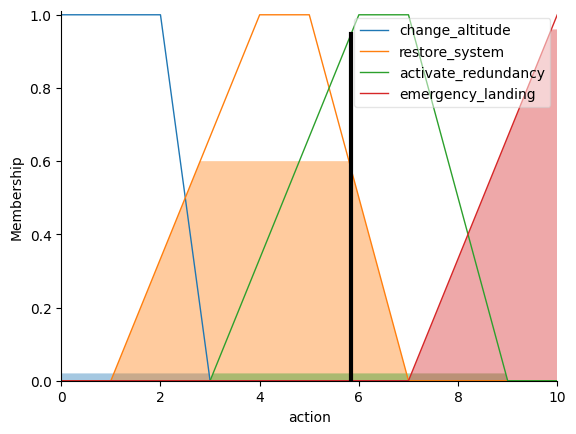

In [7]:
def get_action(state, risk_value=0, time_value=0, energy_value=0, complexity_value=0, impact_value=0):
    actions(state)
    rule_set = rules(state)
    action_ctrl = ctrl.ControlSystem(rule_set)
    action_simulation = ctrl.ControlSystemSimulation(action_ctrl)

    action_simulation.input['risk'] = risk_value
    action_simulation.input['time'] = time_value
    action_simulation.input['energy'] = energy_value
    action_simulation.input['complexity'] = complexity_value
    action_simulation.input['impact'] = impact_value

    action_simulation.compute()
    
    # Get the defuzzified output value
    action_value = action_simulation.output['action']

    action.view(sim=action_simulation)
    #action_simulation.print_state()
    
    # Determine the action with the highest membership at this value
    action_memberships = {}
    for action_name in action.terms:
        action_memberships[action_name] = fuzz.interp_membership(action.universe, action[action_name].mf, action_value)
    
    print(action_memberships)
    # Choses the action based on the highest membership value 
    chosen_action = max(action_memberships, key=action_memberships.get)
    return chosen_action

print(get_action(state= "S3", risk_value= 99, time_value= 1, energy_value= 2,complexity_value= 20,impact_value= 30))

{'change_altitude': 0.0, 'restore_system': 1.0, 'activate_redundancy': 0.4696062242237883, 'emergency_landing': 0.0}
restore_system
{'change_altitude': 0.0, 'restore_system': 1.0, 'activate_redundancy': 0.6468656223147597, 'emergency_landing': 0.0}
restore_system
{'change_altitude': 0.0, 'restore_system': 0.33698760704441755, 'activate_redundancy': 1.0, 'emergency_landing': 0.0}
activate_redundancy
{'change_altitude': 0.0, 'restore_system': 1.0, 'activate_redundancy': 0.37657234660033156, 'emergency_landing': 0.0}
restore_system
{'change_altitude': 0.0, 'restore_system': 1.0, 'activate_redundancy': 0.4807080610021786, 'emergency_landing': 0.0}
restore_system
{'change_altitude': 0.0, 'restore_system': 0.7477063499259522, 'activate_redundancy': 0.8348624333826985, 'emergency_landing': 0.0}
activate_redundancy
{'change_altitude': 0.0, 'restore_system': 0.8773280877634448, 'activate_redundancy': 0.7484479414910368, 'emergency_landing': 0.0}
restore_system
{'change_altitude': 0.396192119643

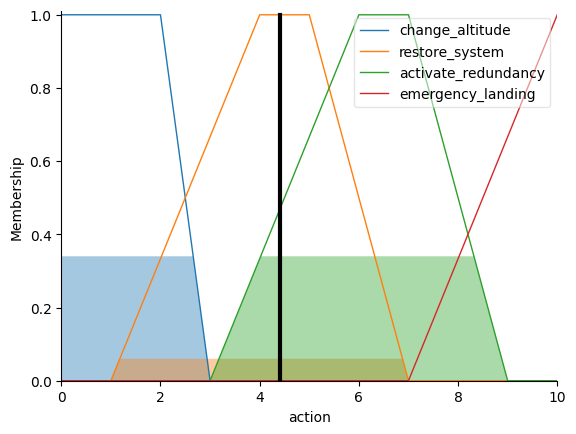

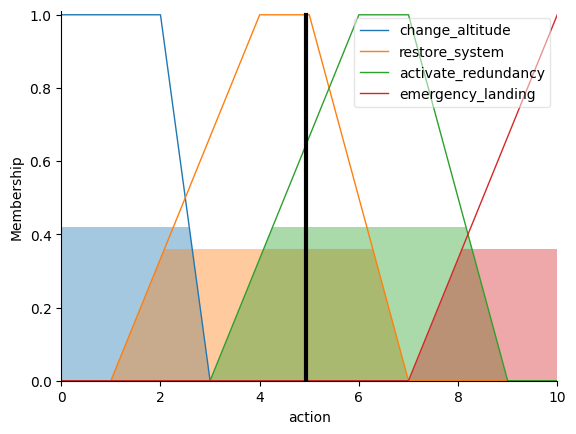

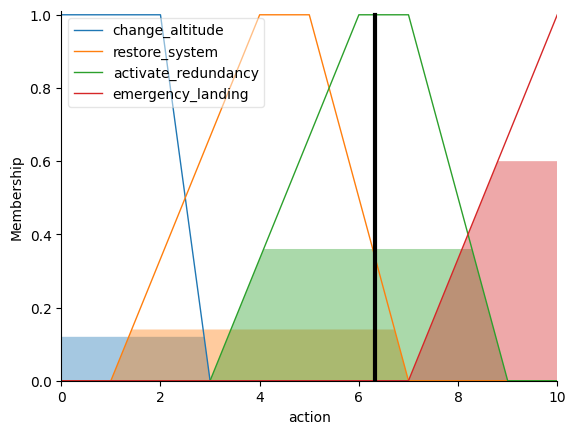

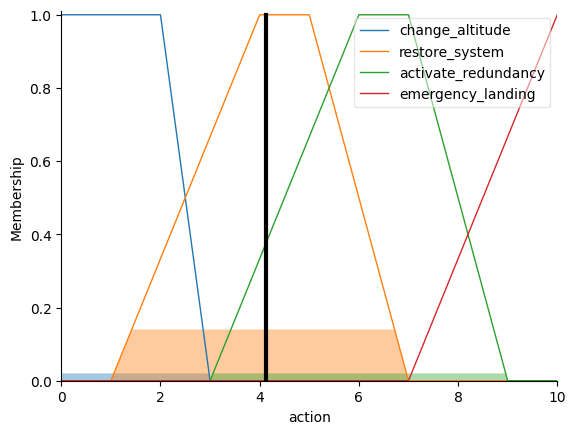

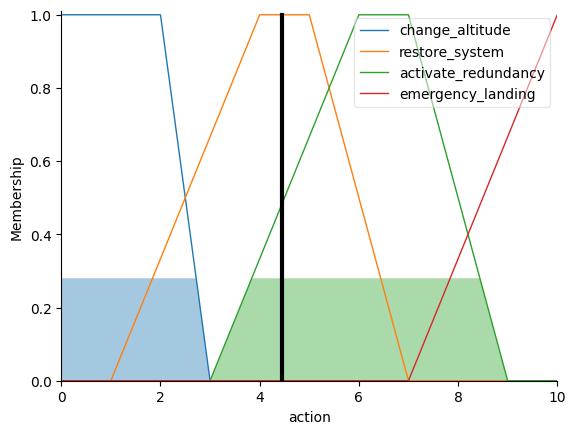

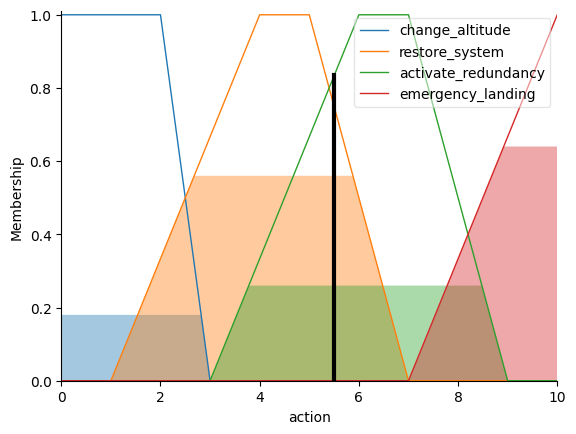

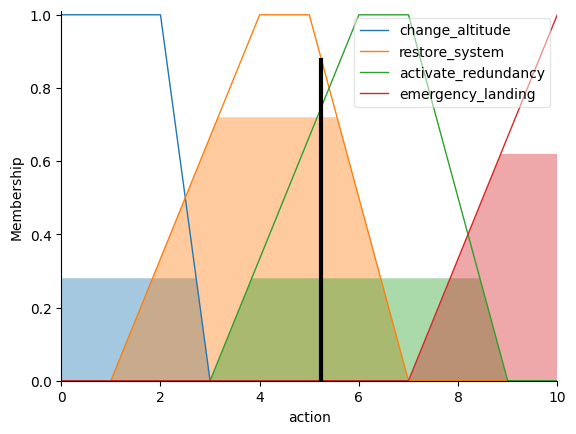

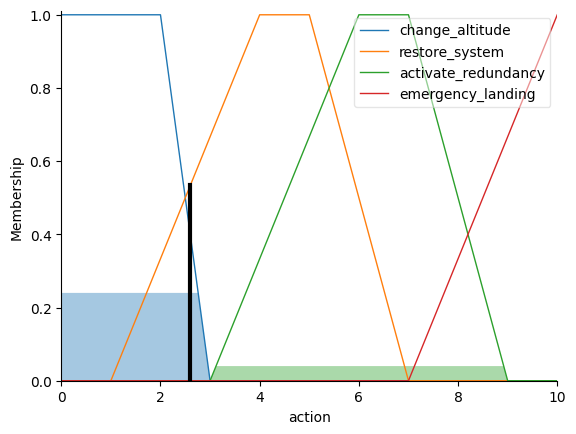

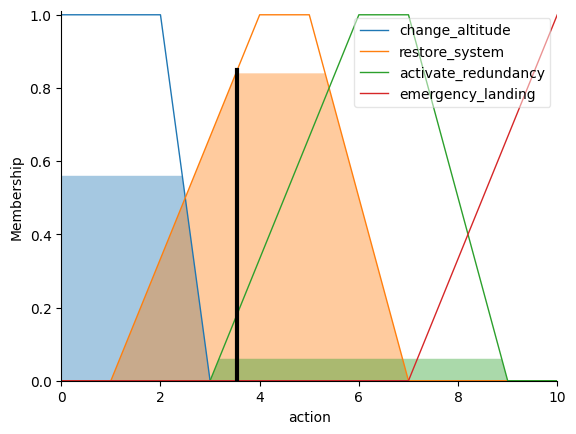

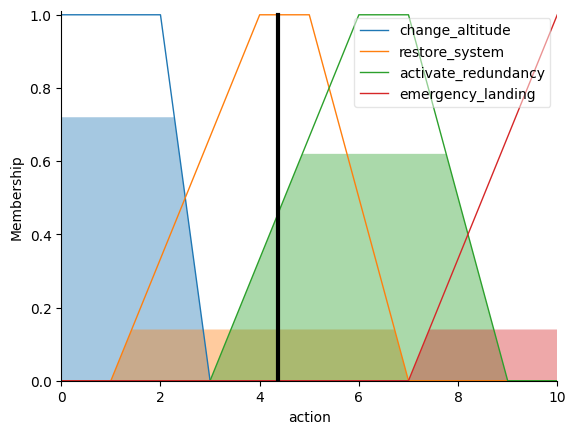

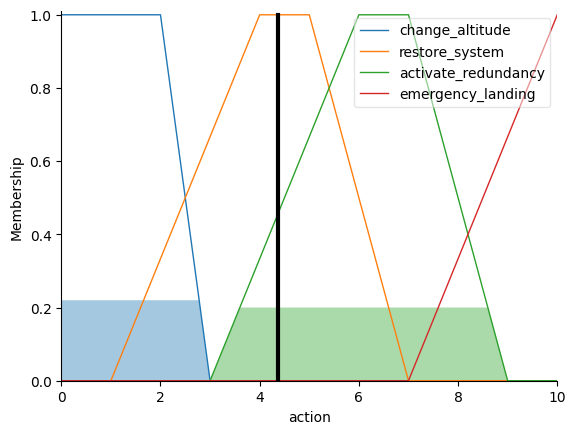

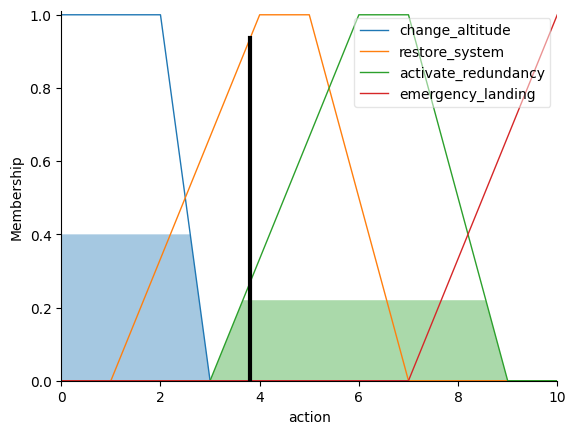

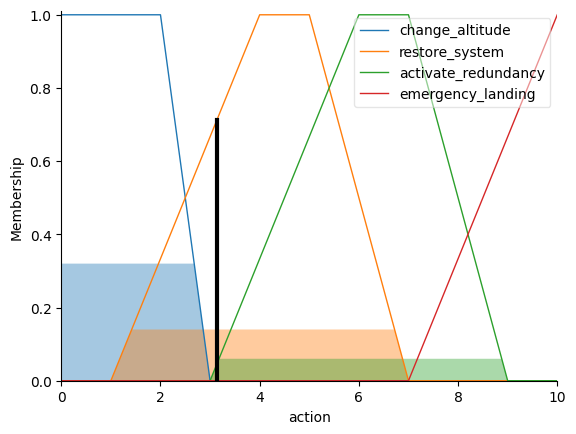

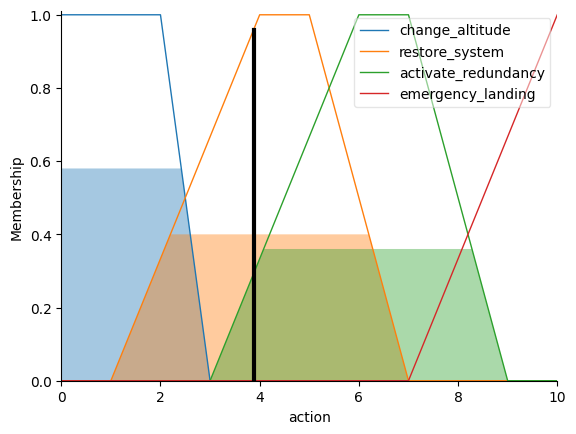

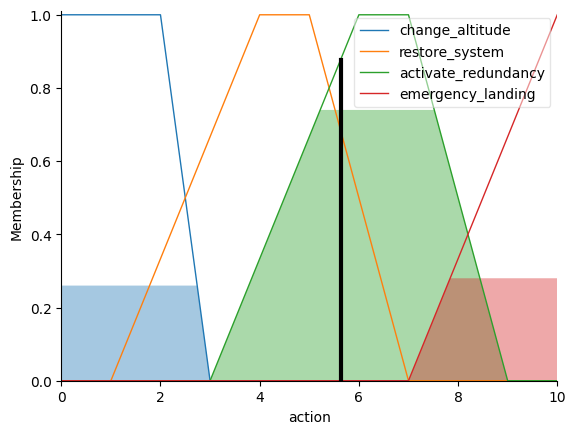

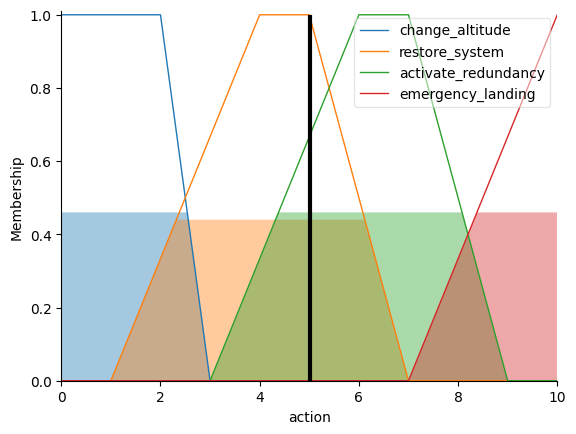

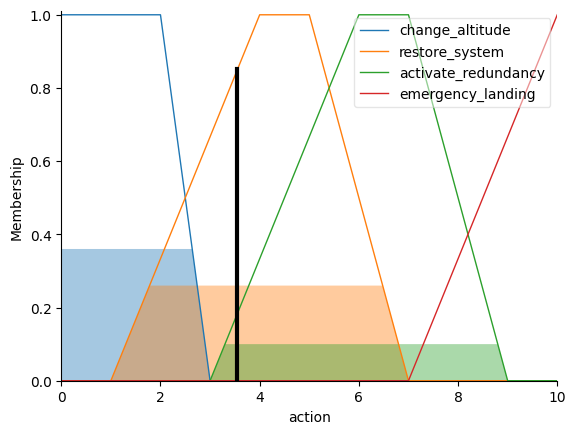

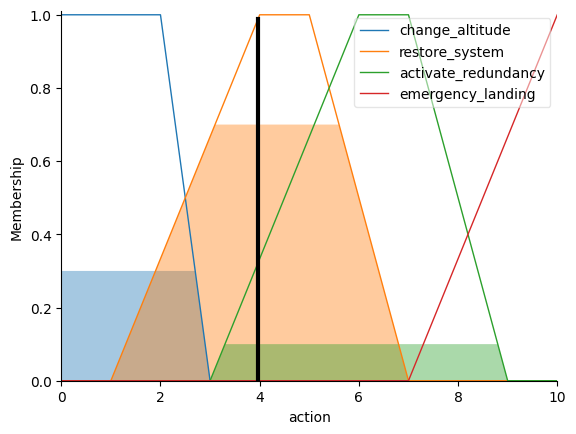

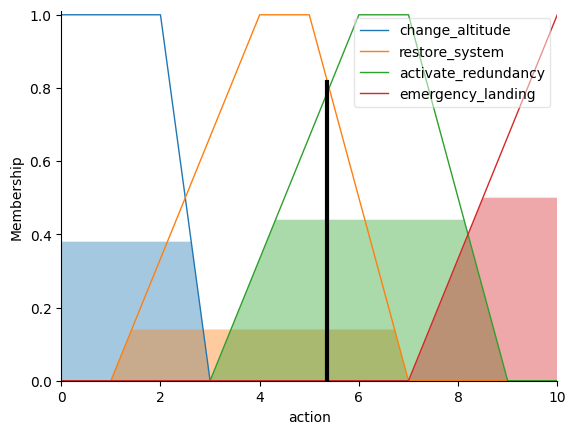

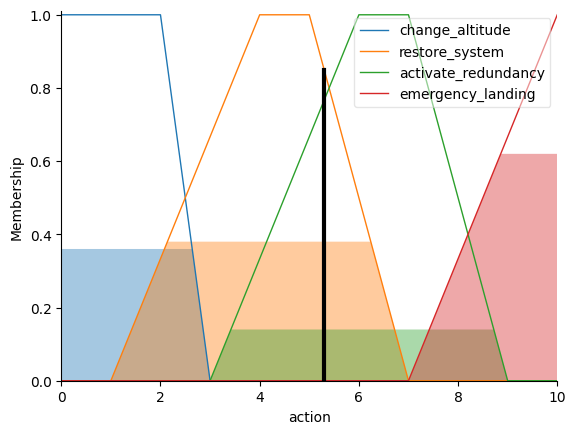

In [8]:
import random
for i in range(0, 20):
    print(get_action(state="S3", 
                     risk_value=random.randint(0, 100), 
                     time_value=random.randint(0, 100), 
                     energy_value=random.randint(0, 100), 
                     complexity_value=random.randint(0, 100), 
                     impact_value=random.randint(0, 100)))
